In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00


In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [4]:
from datasets import load_dataset

dataset = load_dataset("Bingsu/Human_Action_Recognition", split='train')

README.md:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/98.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

In [5]:
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 10080
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 2520
    })
})

In [7]:
labels = dataset['train'].features['labels'].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'calling': 0, 'clapping': 1, 'cycling': 2, 'dancing': 3, 'drinking': 4, 'eating': 5, 'fighting': 6, 'hugging': 7, 'laughing': 8, 'listening_to_music': 9, 'running': 10, 'sitting': 11, 'sleeping': 12, 'texting': 13, 'using_laptop': 14}
{0: 'calling', 1: 'clapping', 2: 'cycling', 3: 'dancing', 4: 'drinking', 5: 'eating', 6: 'fighting', 7: 'hugging', 8: 'laughing', 9: 'listening_to_music', 10: 'running', 11: 'sitting', 12: 'sleeping', 13: 'texting', 14: 'using_laptop'}


In [8]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=265x190>,
 'labels': 7}

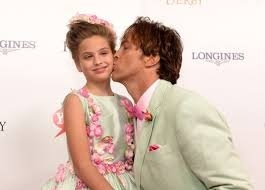

In [9]:
dataset['train'][0]['image']

In [10]:
id2label[dataset['train'][0]['labels']]

'hugging'

## Image Preprocessing

In [11]:
from transformers import AutoImageProcessor #-> like Tokenizer

model_ckpt = "google/vit-base-patch16-224-in21k"
# model_ckpt = "microsoft/swinv2-tiny-patch4-window16-256"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [12]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (image_processor.size['shortest_edge'] if 'shortest_edge' in image_processor.size 
        else (image_processor.size['height'], image_processor.size['width']))

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(batch):
    batch['pixel_values'] = [_transforms(img.convert('RGB')) for img in batch['image']]

    del batch['image']

    return batch

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [13]:
dataset = dataset.with_transform(transforms)

## Evaluate the model


In [14]:

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## Vision Transformer (ViT) Fine Tuning for Image Classification

In [15]:
from transformers import AutoModelForImageClassification
import torch

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id
).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

In [17]:
from transformers import TrainingArguments, Trainer


args = TrainingArguments(
    output_dir="train_dir",
    remove_unused_columns=False,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


trainer = Trainer(
    model = model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.002600,1.342683,0.716667
2,1.239400,1.041742,0.755952
3,1.008900,0.959151,0.755159
4,0.834900,0.919343,0.758730
5,0.760200,0.848164,0.781746


TrainOutput(global_step=3150, training_loss=1.1045191882905505, metrics={'train_runtime': 1231.4439, 'train_samples_per_second': 40.928, 'train_steps_per_second': 2.558, 'total_flos': 3.906051336688435e+18, 'train_loss': 1.1045191882905505, 'epoch': 5.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.8710876703262329,
 'eval_accuracy': 0.7678571428571429,
 'eval_runtime': 20.4147,
 'eval_samples_per_second': 123.44,
 'eval_steps_per_second': 7.74,
 'epoch': 5.0}

In [20]:
trainer.save_model('vit-human-pose-classification')

## Classification Report and Confusion Matrix

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
logits = trainer.predict(dataset['test'])

In [23]:
logits = logits.predictions

In [24]:
y_pred = np.argmax(logits, axis=1)

In [25]:
y_true = [x['labels'] for x in dataset['test']]

In [26]:
print(classification_report(y_true, y_pred, target_names=labels))

                    precision    recall  f1-score   support

           calling       0.70      0.70      0.70       200
          clapping       0.85      0.76      0.81       174
           cycling       0.93      0.91      0.92       147
           dancing       0.80      0.86      0.83       153
          drinking       0.78      0.77      0.78       182
            eating       0.90      0.86      0.88       179
          fighting       0.78      0.82      0.80       152
           hugging       0.78      0.80      0.79       167
          laughing       0.76      0.76      0.76       174
listening_to_music       0.74      0.71      0.73       170
           running       0.82      0.83      0.82       166
           sitting       0.61      0.66      0.63       155
          sleeping       0.83      0.87      0.85       165
           texting       0.64      0.60      0.62       160
      using_laptop       0.73      0.73      0.73       176

          accuracy                    

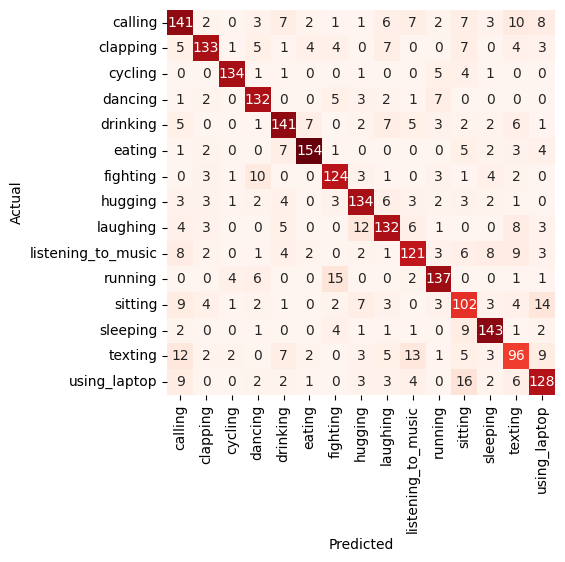

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Prediction on Real Image

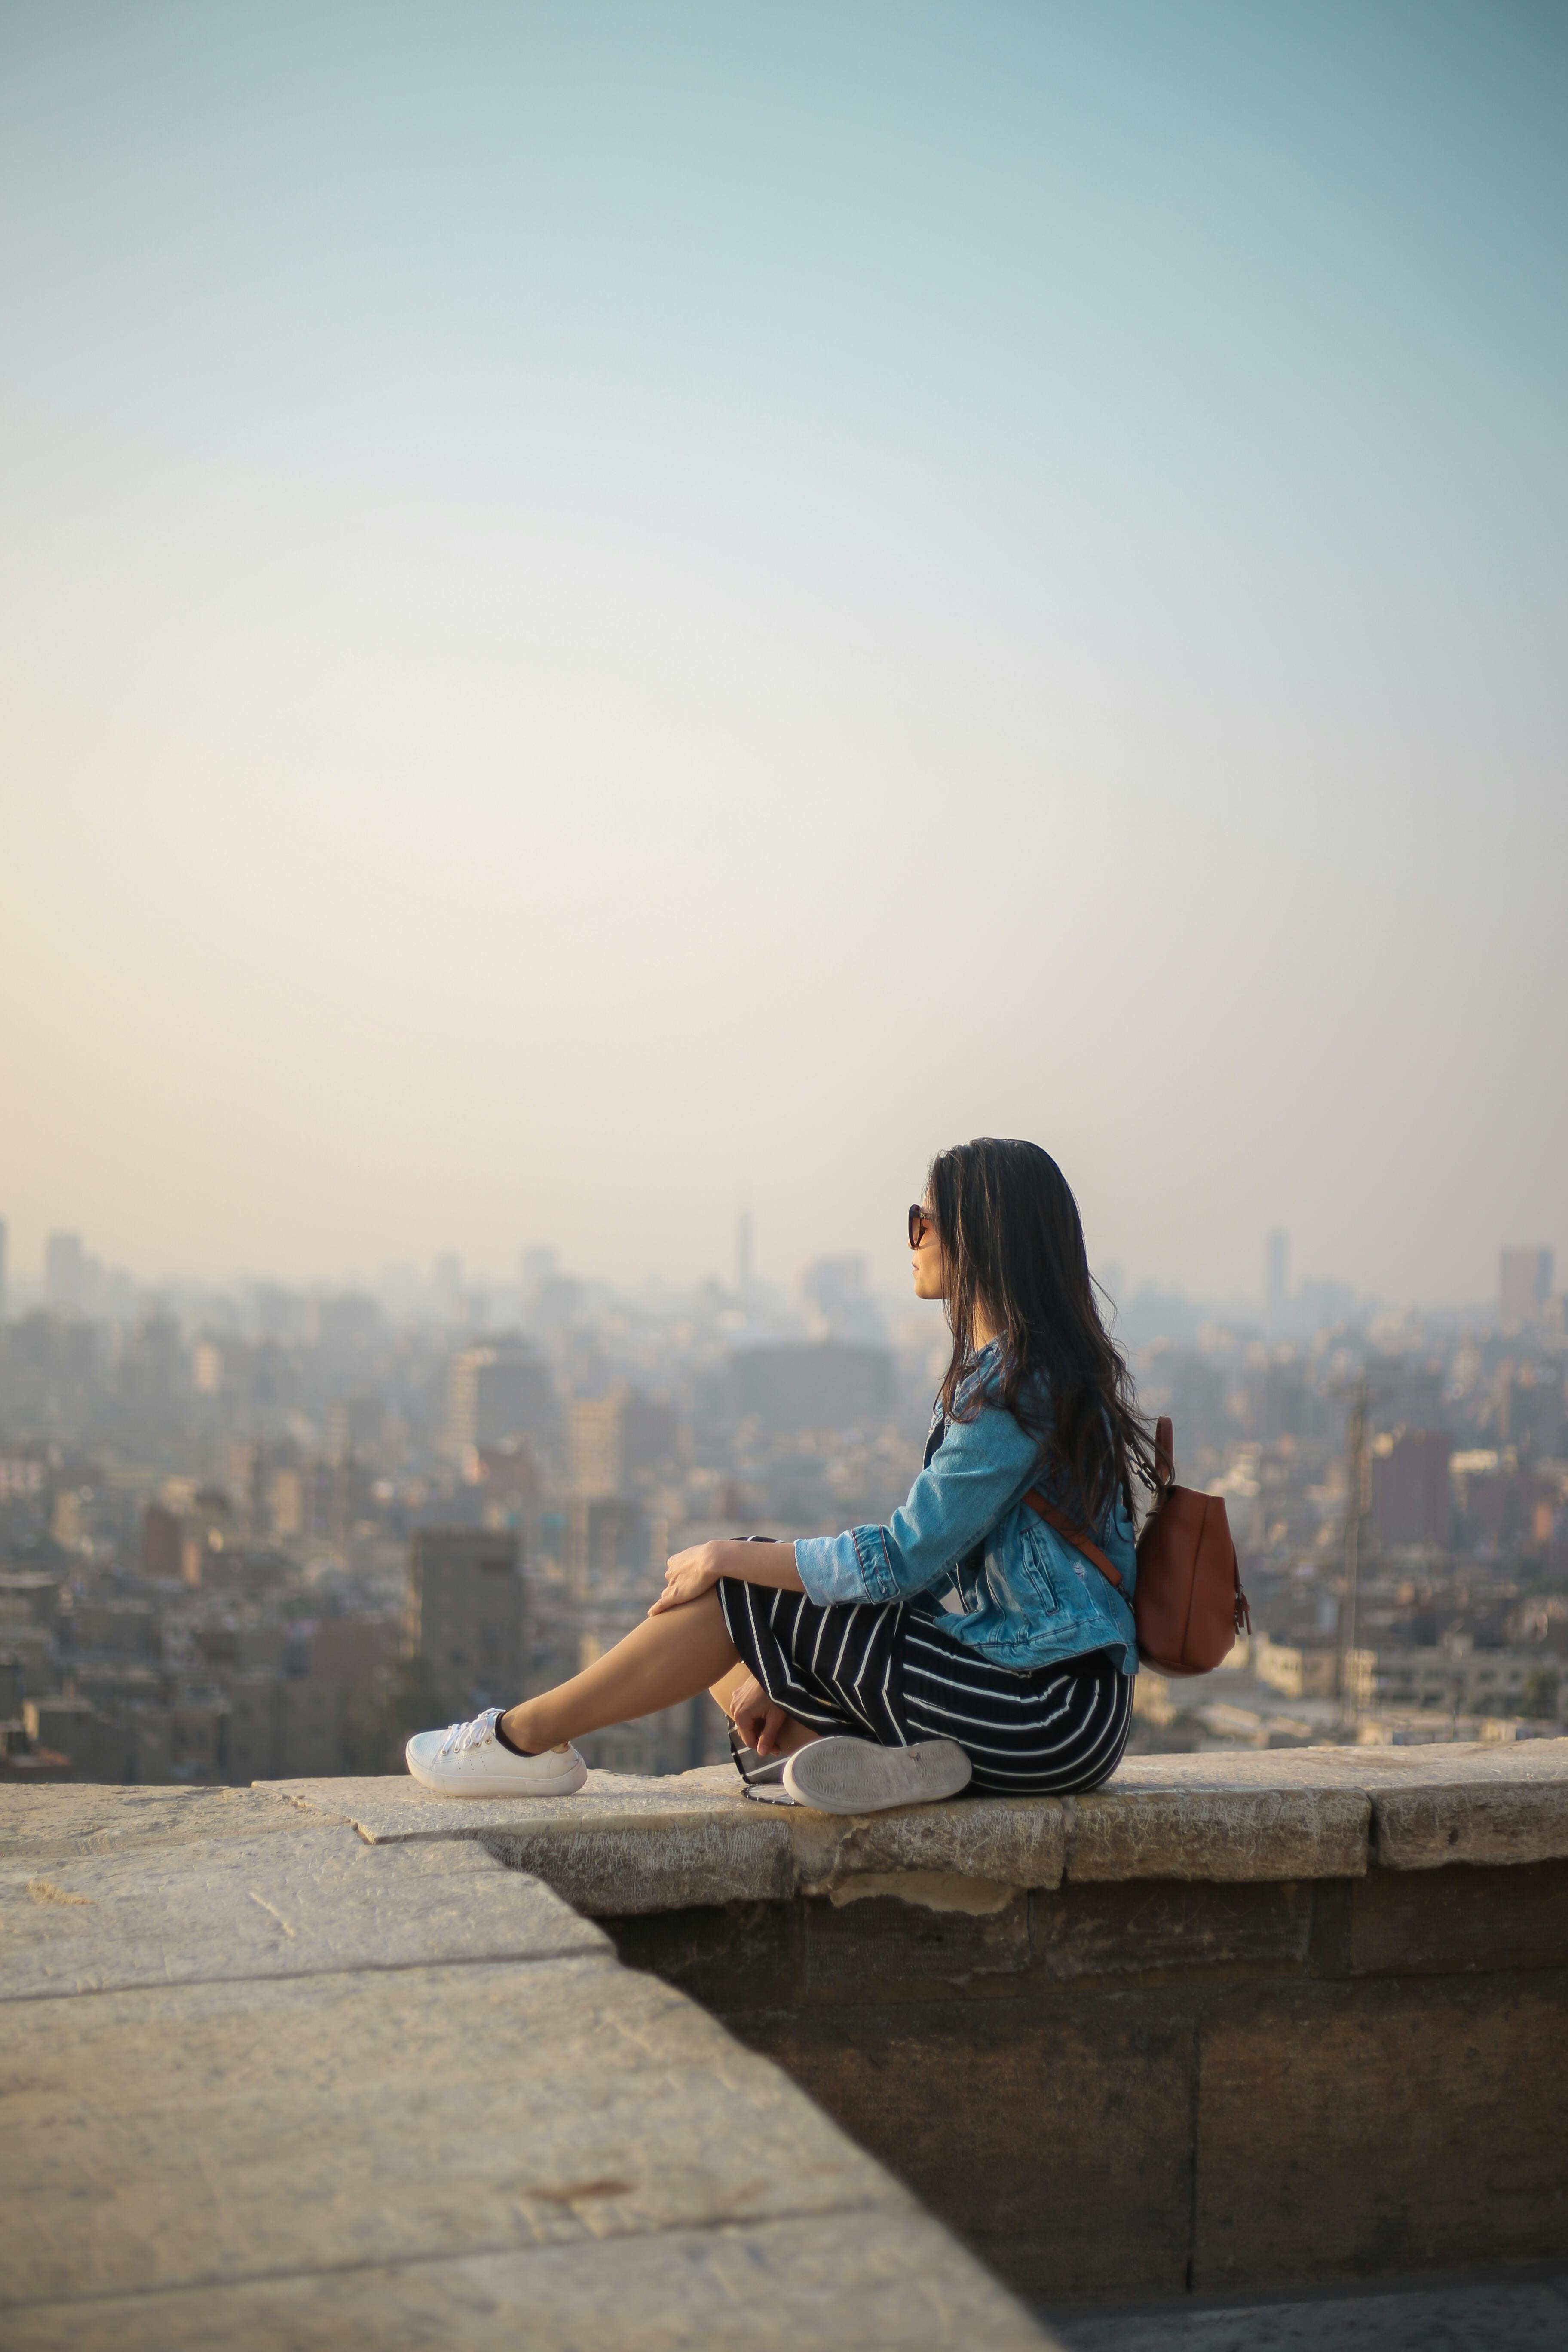

In [28]:
# Import the necessary modules
import requests
from IPython.display import Image, display
from io import BytesIO

# URL of the image
url = "https://images.pexels.com/photos/1755385/pexels-photo-1755385.jpeg"

# Send a HTTP request to the URL and save the response from server in a response object called r
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the response content as an image
    image = Image(data=BytesIO(response.content).read(), format='jpeg')

    # Display the image
    display(image)
else:
    print(f"Failed to retrieve image. Status code: {response.status_code}")


In [29]:
from transformers import pipeline
from transformers import AutoImageProcessor

model_ckpt = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt, use_fast=True)

pipe = pipeline(
    'image-classification', 
    model='vit-human-pose-classification', 
    image_processor=image_processor
)



output = pipe(url)
output

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'sitting', 'score': 0.9076429009437561},
 {'label': 'using_laptop', 'score': 0.8686770796775818},
 {'label': 'calling', 'score': 0.696711540222168},
 {'label': 'texting', 'score': 0.6111845374107361},
 {'label': 'listening_to_music', 'score': 0.586537778377533}]

In [30]:
image_processor.save_pretrained('vit-human-pose-classification')

['vit-human-pose-classification/preprocessor_config.json']

In [31]:
# Load the model and image processor from the local directory
from transformers import AutoImageProcessor, AutoModel

local_directory = 'vit-human-pose-classification'
image_processor = AutoImageProcessor.from_pretrained(local_directory, use_fast=True)
model = AutoModel.from_pretrained(local_directory, local_files_only=True)

Some weights of ViTModel were not initialized from the model checkpoint at vit-human-pose-classification and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
